In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from typing import Optional
from IPython.display import display, HTML
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [4]:
# Data import

def yahoo_reader(ticker, start='2020-01-01', end='2022-12-31', freq=None, calc_return=True, calc_log=False):
    """
    import daily data from yahoo finance
    """
    df = pdr.get_data_yahoo(ticker, start=start, end=end).fillna(method='ffill')['Adj Close']
    
    if freq is not None:
        df = df.resample(freq).last()   # 각 주 또는 각 월의 마지막 날에 해당하는 데이터 import

    if calc_return == True:
        df = df.pct_change().fillna(0)

    if calc_log == True:
        df = np.log(df)

    df = df[ticker] # 입력 티커 순으로 정렬
    df = df.dropna()
    df = df[df.index >= start]  # start 일자 이후의 데이터만 선택
    df = df.iloc[1:, :]
     
    return df


# Individual assets performance

def asset_performance(returns, recur, perf_chart=True):
    """ 
    performance of individual assets
    """
    cumulative_returns = (1 + returns).cumprod()
    cumulative_returns_scaling = cumulative_returns / cumulative_returns.iloc[0]

    if recur == 'daily':
        num_years = len(cumulative_returns) / 252
    elif recur == 'weekly':
        num_years = len(cumulative_returns) / 52
    elif recur == 'monthly':
        num_years = len(cumulative_returns) / 12

    cagr = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0]) ** (1/num_years) - 1
    volatility = returns.std() * np.sqrt(52)

    asset_perf = pd.DataFrame()
    asset_perf['cagr'] = cagr.T
    asset_perf['volatility'] = volatility.T
    asset_perf['sharpe'] = cagr.T / volatility.T

    if perf_chart == True:
        cumulative_returns_scaling.plot()
    
    return asset_perf

In [5]:
# Portfolio Optimization

def optimize_gmv(cov_mat: pd.DataFrame, no_short=True, opt: Optional[dict] = None):
    """ 
    GMV (Global Minimum Variance) 
    Parameter : variance

    min     portfolio variance
    s.t.    sum of weights = 1
            and other constraints
    """

    # 목적함수 정의
    n = cov_mat.shape[1]
    w = cp.Variable((n, 1)) 
    objective = cp.Minimize(cp.quad_form(w, cov_mat))   # cp.quad_form(w, cov_mat) = wT * cov_mat * w
    
    # 제약조건 정의
    constraints = [sum(w) == 1] 

    if no_short == True:
        constraints.append(w >= 0)

    if opt is not None: 
        if 'lowerbound' in opt:
            constraints.append(w >= opt['lowerbound'])  # 제약조건 - 최소비중
        if 'upperbound' in opt:
            constraints.append(w <= opt['upperbound'])  # 제약조건 - 최대비중

    # 최적화
    problem = cp.Problem(objective, constraints)    # 최적화 문제 정의
    problem.solve(verbose=False, solver=cp.CVXOPT)  # 최적화 문제 해결 (verbose = 출력 메시지 확인 여부)

    if problem.status == "optimal":
        w_opt = np.array(w.value).flatten()
    elif opt is not None:
        warnings.warn('optimize_gmv not optimized, running without options')
        w_opt = optimize_gmv(cov_mat, no_short=False)
    else:
        warnings.warn('optimize_gmv not optimized, returning 1/n')

    return w_opt


def optimize_mvp(mean_vec: pd.DataFrame, cov_mat: pd.DataFrame, req_ret=0.01, no_short=True, opt: Optional[dict] = None):
    """ 
    MVP (Minimum Variance Portfolio) 
    Parameter : expected returns, variance

    min     portfolio variance
    s.t.    sum of weights = 1
            portfolio mean return >= req_ret
            and other constraints
    """

    # 목적함수 정의
    n = cov_mat.shape[1]
    w = cp.Variable((n, 1)) 
    objective = cp.Minimize(cp.quad_form(w, cov_mat))   # cp.quad_form(w, cov_mat) = wT * cov_mat * w

    # 제약조건 정의
    constraints = [sum(w) == 1, cp.matmul(mean_vec, w) >= req_ret] 

    if no_short == True:
        constraints.append(w >= 0)

    if opt is not None: 
        if 'lowerbound' in opt:
            constraints.append(w >= opt['lowerbound'])  # 제약조건 - 최소비중
        if 'upperbound' in opt:
            constraints.append(w <= opt['upperbound'])  # 제약조건 - 최대비중

    # 최적화
    problem = cp.Problem(objective, constraints)    # 최적화 문제 정의
    problem.solve(verbose=False, solver=cp.CVXOPT)  # 최적화 문제 해결 (verbose = 출력 메시지 확인 여부)

    if problem.status == "optimal":
        w_opt = np.array(w.value).flatten()
    elif opt is not None:
        warnings.warn('optimize_mvp not optimized, running without options')
        w_opt = optimize_mvp(cov_mat, no_short=False)
    else:
        warnings.warn('optimize_mvp not optimized, returning 1/n')

    return w_opt


def optimize_utility(mean_vec: pd.DataFrame, cov_mat: pd.DataFrame, v_lambda, no_short=True, opt: Optional[dict] = None):
    """
    MVO by utility function 
    Parameter : mean, variance, lambda(utility)

    max     portfolio mean - 0.5 * lambda * portfolio variance
    s.t.    sum of weights = 1
            and other constraints
    """

    # 목적함수 정의
    n = mean_vec.shape[0]
    w = cp.Variable((n, 1)) 
    objective = cp.Maximize(cp.mat_mul(mean_vec, w) - 0.5 * v_lambda * cp.quad_form(w, cov_mat))
    
    # 제약조건 정의
    constraints = [sum(w) == 1] 

    if no_short == True:
        constraints.append(w >= 0)

    if opt is not None: 
        if 'lowerbound' in opt:
            constraints.append(w >= opt['lowerbound'])  # 제약조건 - 최소비중
        if 'upperbound' in opt:
            constraints.append(w <= opt['upperbound'])  # 제약조건 - 최대비중

    # 최적화 
    problem = cp.Problem(objective, constraints)    
    problem.solve(verbose=False, solver=cp.CVXOPT)  # 최적화 문제 해결 (verbose = 출력 메시지 확인 여부)

    if problem.status == "optimal":
        w_opt = np.array(w.value).flatten()
    elif opt is not None:
        warnings.warn('optimize_utility not optimized, running without options')
        w_opt = optimize_utility(cov_mat, no_short=False)
    else:
        warnings.warn('optimize_utility not optimized, returning 1/n')

    return w_opt

In [6]:
# Risk Allocation

def risk_contribution(weight, cov_mat, get_proportion=False):
    """ 
    compute risk contribution of each asset
    """
    total_port_var = weight.T @ cov_mat @ weight

    if get_proportion == True:
        return np.multiply(cov_mat @ weight, weight.T) / total_port_var
    else:
        return np.multiply(cov_mat @ weight, weight.T) / np.sqrt(total_port_var)
    

def plot_risk_contribution(weight, cov_mat, get_proportion=False, asset_names=None, title=None):
    """ 
    visualization by plotting
    """
    rc = risk_contribution(weight, cov_mat, get_proportion=get_proportion)
    plt.figure(figsize=(8, 4))

    if asset_names is not None:
        plt.bar(asset_names, rc)
    else:
        plt.bar(['Asset' + str(x + 1) for x in range(len(rc))], rc)

    if title is None:
        if get_proportion:
            plt.title('Risk Contribution (proportion)')
        else:
            plt.title('Risk Contribution')
    else:
        if get_proportion:
            plt.title('Risk Contribution (proportion)' + ': ' + title)
        else:
            plt.tile('Risk Contribution' + ': ' + title)
    
    plt.show()


def target_risk_contribution(target_risk, cov_mat: pd.DataFrame, opt: Optional[dict] = None, verbose = False):
    """ 
    
    """

    # 목적함수 정의
    n = cov_mat.shape[1]
    w = cp.Variable((n, 1)) 
    k = cp.Variable((1, 1))
    objective = cp.Minimize(cp.quad_form(w, cov_mat))

    # 제약조건 정의 - (1. 포트폴리오의 전체 리스크가 1 이상, 개별자산의 비중 0 이상, 비중 합은 k)
    constraints = [sum(cp.multiply(cp.reshape(target_risk, (n, 1)), cp.log(w))) >= 1, w >= 0, sum(w) == k]

    if opt is not None:
        if 'req_ret' in opt and 'mean_vec' in opt:
            constraints.append(cp.matmul(opt['mean_vec'], w) >= k * opt['req_ret'])
        if 'lowerbound' in opt:
            constraints.append(w >= opt['lowerbound'] * k)  # 제약조건 - 최소비중
        if 'upperbound' in opt:
            constraints.append(w <= opt['upperbound'] * k)  # 제약조건 - 최대비중
    
    # 최적화
    problem = cp.Problem(objective, constraints)    
    problem.solve(verbose=False, solver=cp.SCS)  # 최적화 문제 해결 (verbose = 출력 메시지 확인 여부)

    if problem.status == "optimal":
        weights = np.abs(w.value) / np.sum(np.abs(w.value)) # 비중 정규화 (비중 합은 1)
        w_opt = np.array(weights).flatten()
    elif opt is not None:
        warnings.warn('target_risk_contribution not optimized, running without options')
        w_opt = target_risk_contribution(target_risk, cov_mat, verbose=verbose)
    else:
        warnings.warn('target_risk_contribution not optimized, returning 1/n')
        w_opt = np.repear(1 / n, n)

    return w_opt

def equal_risk_contribution(cov_mat):
    """
    """
    n = cov_mat.shape[0]
    
    return target_risk_contribution(target_risk = np.repeat(1 / n, n), cov_mat=cov_mat)    

In [7]:
def target_risk_contribution(target_risk, cov_mat: pd.DataFrame, opt: Optional[dict] = None, verbose = False):
    """ 
    
    """

    # 목적함수 정의
    n = cov_mat.shape[1]
    w = cp.Variable((n, 1)) 
    k = cp.Variable((1, 1))
    objective = cp.Minimize(cp.quad_form(w, cov_mat))

    # 제약조건 정의 - (1. 포트폴리오의 전체 리스크가 1 이상, 개별자산의 비중 0 이상, 비중 합은 k)
    constraints = [sum(cp.multiply(cp.reshape(target_risk, (n, 1)), cp.log(w))) >= 1, w >= 0, sum(w) == k]

    if opt is not None:
        if 'req_ret' in opt and 'mean_vec' in opt:
            constraints.append(cp.matmul(opt['mean_vec'], w) >= k * opt['req_ret'])
        if 'lowerbound' in opt:
            constraints.append(w >= opt['lowerbound'] * k)  # 제약조건 - 최소비중
        if 'upperbound' in opt:
            constraints.append(w <= opt['upperbound'] * k)  # 제약조건 - 최대비중
    
    # 최적화
    problem = cp.Problem(objective, constraints)    
    problem.solve(verbose=False, solver=cp.SCS)  # 최적화 문제 해결 (verbose = 출력 메시지 확인 여부)

    if problem.status == "optimal":
        weights = np.abs(w.value) / np.sum(np.abs(w.value)) # 비중 정규화 (비중 합은 1)
        w_opt = np.array(weights).flatten()
    elif opt is not None:
        warnings.warn('target_risk_contribution not optimized, running without options')
        w_opt = target_risk_contribution(target_risk, cov_mat, verbose=verbose)
    else:
        warnings.warn('target_risk_contribution not optimized, returning 1/n')
        w_opt = np.repear(1 / n, n)

    return w_opt

def equal_risk_contribution(cov_mat):
    """
    """
    n = cov_mat.shape[0]
    
    return target_risk_contribution(target_risk = np.repeat(1 / n, n), cov_mat=cov_mat)

[*********************100%%**********************]  6 of 6 completed


Ticker,IWV,EFA,EEM,AGG,GSG,REET
Date,,,,,,
2018-01-12,0.016561,0.015895,0.007734,-0.002751,0.024390,-0.019395
2018-01-19,0.008450,0.008571,0.018784,-0.005150,-0.005952,0.005538
2018-01-26,0.019772,0.015109,0.032514,0.001756,0.027545,0.016916
2018-02-02,-0.037950,-0.035880,-0.058180,-0.008577,-0.016900,-0.034816
2018-02-09,-0.050138,-0.054583,-0.053619,-0.004104,-0.063426,-0.039680
...,...,...,...,...,...,...
2023-12-01,0.012004,0.008545,0.004805,0.020561,-0.013006,0.039617
2023-12-08,0.002889,-0.000547,-0.018122,0.000620,-0.027818,0.002628
2023-12-15,0.026763,0.016407,0.024866,0.021505,0.011546,0.054609


,cagr,volatility,sharpe
Ticker,,,
IWV,0.105554,0.201211,0.524592
EFA,0.034056,0.190023,0.179221
EEM,-0.012024,0.200115,-0.060088
AGG,0.010011,0.057680,0.173554
GSG,0.029999,0.240149,0.124920
REET,0.031826,0.255180,0.124720


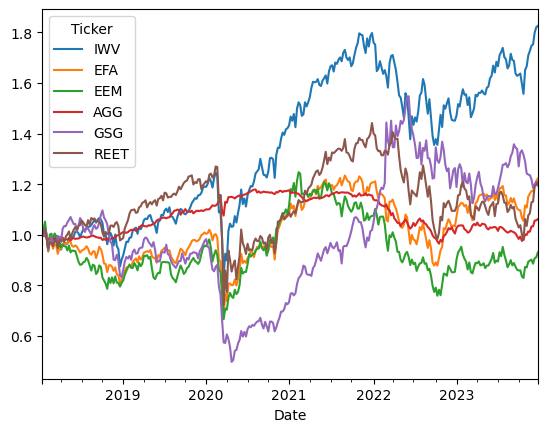

In [8]:
"""
IWV : iShares Russell 3000 ETF
EFA : iShares MSCI EAFE ETF
EEM : iShares MSCI Emerging Markets ETF
AGG : iShares Core US Aggregate Bond ETF
GSG : iShares S&P GSCI Commodity-Indexex Trust
REET : iShares Global REIT ETF

"""

start_date = '2018-01-01'
end_date = '2023-12-31'
freq = 'W-FRI'
tickers = ['IWV', 'EFA', 'EEM', 'AGG', 'GSG', 'REET']

df_rets = yahoo_reader(tickers, start_date, end_date, freq=freq)
display(df_rets)

asset_perf = asset_performance(df_rets, recur='weekly', perf_chart=True)
display(asset_perf)

,IWV,EFA,EEM,AGG,GSG,REET,portfolio_returns,portfolio_volatility
GMV,0.0499,0.1530,0.1195,0.5000,0.1776,0.0,0.0322,0.0362
MVP_target3%,0.0497,0.1531,0.1195,0.5000,0.1777,0.0,0.0322,0.0362
MVP_target5%,0.2456,0.0511,0.0260,0.5000,0.1773,0.0,0.0500,0.0370
MVP_target7%,0.5000,0.0000,0.0000,0.4486,0.0514,0.0,0.0700,0.0435
MVP_target9%,0.5000,0.1078,0.0000,0.0409,0.3513,0.0,0.0900,0.0638


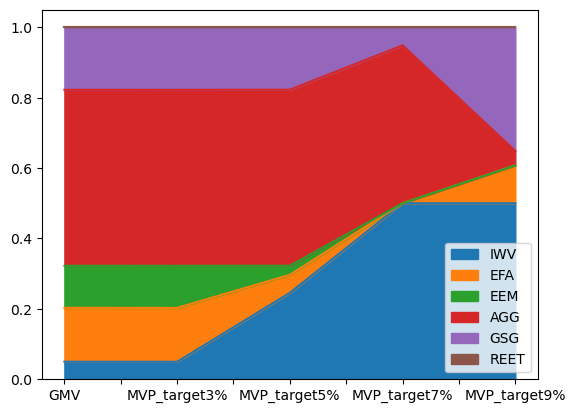

In [9]:
# parameter setting
opt = {'upperbound' : 0.5}
dt = 52

mean_vec = df_rets.mean() * 52
cov_mat = df_rets.cov() * np.sqrt(52)

# optimal weight & performance
w_gmv = optimize_gmv(cov_mat, opt=opt)

req_ret = 0.03 
w_3 = optimize_mvp(mean_vec, cov_mat, req_ret=req_ret, opt=opt)

req_ret = 0.05 
w_5 = optimize_mvp(mean_vec, cov_mat, req_ret=req_ret, opt=opt)

req_ret = 0.07 
w_7 = optimize_mvp(mean_vec, cov_mat, req_ret=req_ret, opt=opt)

req_ret = 0.09 
w_9 = optimize_mvp(mean_vec, cov_mat, req_ret=req_ret, opt=opt)

df_pfo = pd.DataFrame([w_gmv, w_3, w_5, w_7, w_9], index=['GMV', 'MVP_target3%', 'MVP_target5%', 'MVP_target7%', 'MVP_target9%'], columns=tickers)

df_pfo['portfolio_returns'] = np.dot(mean_vec, df_pfo.T)
df_pfo['portfolio_volatility'] = np.sqrt(np.diag(np.dot(df_pfo.iloc[:, :-1], np.dot(cov_mat, df_pfo.iloc[:, :-1].T))))
df_pfo = df_pfo.round(4)

df_pfo.iloc[:, :-2].plot.area()
df_pfo

,IWV,EFA,EEM,AGG,GSG,REET,returns,volatility
MVO_mvp,0.3207,0.0000,0.000,0.6248,0.0545,0.0,0.05,0.0329
MVO_mvp_c,0.2456,0.0511,0.026,0.5000,0.1773,0.0,0.05,0.0370


<Axes: >

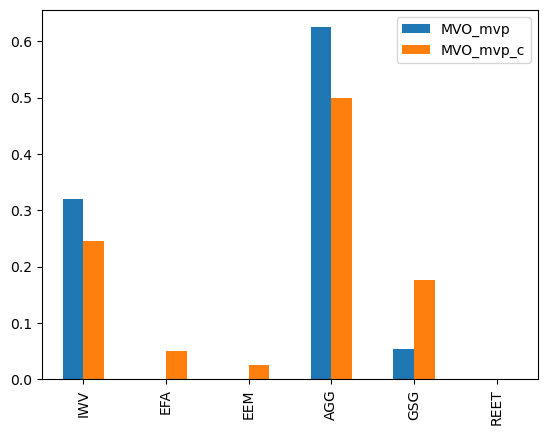

In [10]:
# parameter setting
dt = 52
req_ret = 0.05
opt = {'upperbound' : 0.5}

mean_vec = df_rets.mean() * dt
cov_mat = df_rets.cov() * np.sqrt(dt)

# MVO - Minimum Variance Portfolio (target 5%)
mvo_mvp = optimize_mvp(mean_vec, cov_mat, req_ret=req_ret)
df_pfo = pd.DataFrame([mvo_mvp], index=['MVO_mvp'], columns=tickers)

# MVO - Minimum Variance Portfolio with constraints (target 5%)
mvo_mvp_c = optimize_mvp(mean_vec, cov_mat, req_ret=req_ret, opt=opt)
df_pfo.loc['MVO_mvp_c'] = mvo_mvp_c

df_pfo['returns'] = np.dot(mean_vec, df_pfo.T)
df_pfo['volatility'] = np.sqrt(np.diag(np.dot(df_pfo.iloc[:, :-1], np.dot(cov_mat, df_pfo.iloc[:, :-1].T))))

display(df_pfo.round(4))

df_pfo = df_pfo.iloc[:, :-2]
df_pfo.T.plot.bar()

,IWV,EFA,EEM,AGG,GSG,REET
MVO_mvp,0.3207,0.0,0.0,0.6248,0.0545,0.0
MVO_rc,0.6716,0.0,0.0,0.2640,0.0644,0.0


,IWV,EFA,EEM,AGG,GSG,REET
MVO_mvp_c,0.2456,0.0511,0.0260,0.5000,0.1773,0.0
MVO_c_rc,0.4391,0.0829,0.0394,0.1475,0.2911,0.0


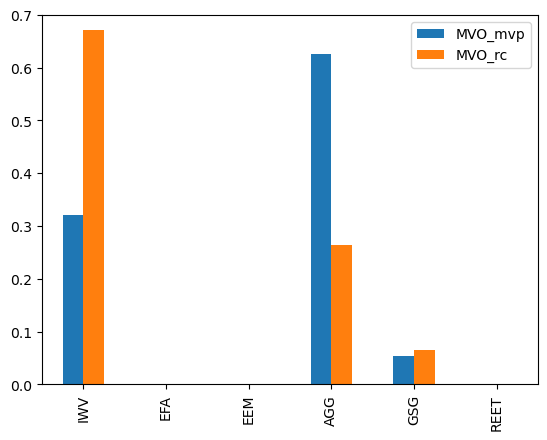

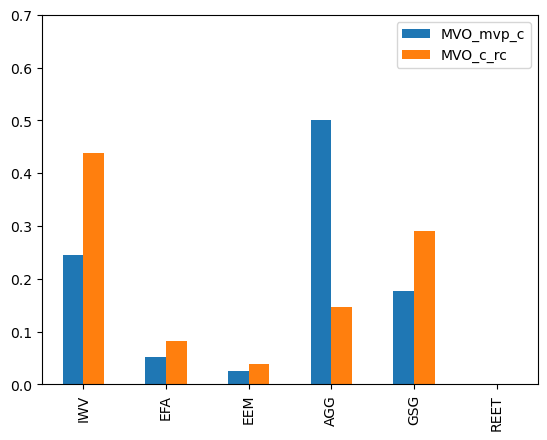

In [11]:
df_rc = pd.DataFrame([risk_contribution(mvo_mvp, cov_mat), 
                      risk_contribution(mvo_mvp_c, cov_mat)], 
                      index = ['MVO_rc', 'MVO_c_rc'], columns=tickers)

df_rc_proportion = pd.DataFrame([risk_contribution(mvo_mvp, cov_mat, get_proportion = True),
                                 risk_contribution(mvo_mvp_c, cov_mat, get_proportion = True)],
                                 index = ['MVO_rc', 'MVO_c_rc'], columns=tickers)

df_merge_mvp = pd.concat([df_pfo.loc['MVO_mvp'], df_rc_proportion.loc['MVO_rc']], axis=1)
df_merge_mvp.plot(kind='bar', ylim=(0, 0.7))
display(df_merge_mvp.T.round(4))

df_merge_mvp_c = pd.concat([df_pfo.loc['MVO_mvp_c'], df_rc_proportion.loc['MVO_c_rc']], axis=1)
df_merge_mvp_c.plot(kind='bar', ylim=(0, 0.7))
display(df_merge_mvp_c.T.round(4))

,IWV,EFA,EEM,AGG,GSG,REET
MVO_mvp,0.321,0.000,0.000,0.625,0.054,0.000
MVO_mvp_c,0.246,0.051,0.026,0.500,0.177,0.000
RP,0.095,0.099,0.103,0.504,0.121,0.077


,IWV,EFA,EEM,AGG,GSG,REET
MVO_rc,0.672,0.000,0.000,0.264,0.064,0.000
MVO_c_rc,0.439,0.083,0.039,0.148,0.291,0.000
RP_rc,0.167,0.167,0.167,0.167,0.167,0.167


<Axes: >

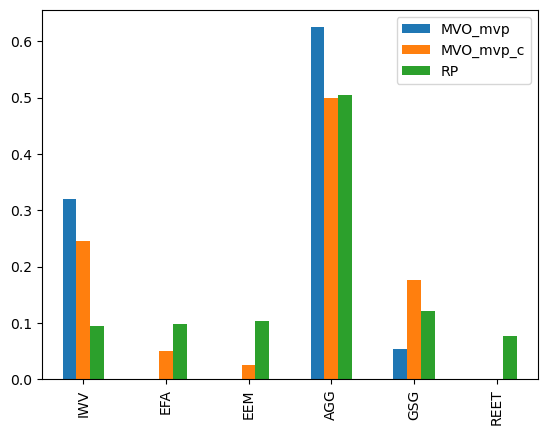

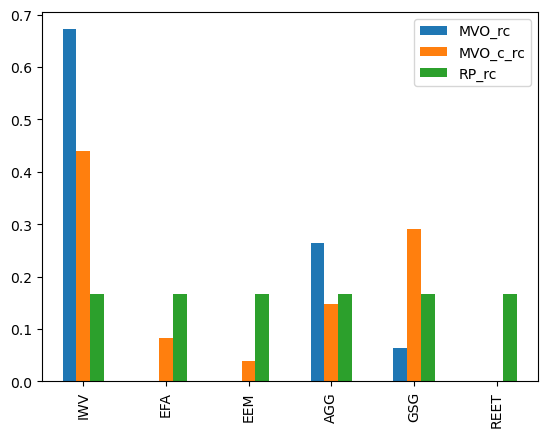

In [12]:
# Risk-Parity Portfolio
rp_weight = equal_risk_contribution(cov_mat)

df_pfo.loc['RP'] = rp_weight
df_rc.loc['RP_rc'] = risk_contribution(rp_weight, cov_mat)
df_rc_proportion.loc['RP_rc'] = risk_contribution(rp_weight, cov_mat, get_proportion=True)

display(df_pfo.round(3))
display(df_rc_proportion.round(3))

df_pfo.T.plot(kind='bar')
df_rc_proportion.T.plot(kind='bar')

# plot_risk_contribution(rp_weight, cov_mat, asset_names=tickers)
# plot_risk_contribution(rp_weight, cov_mat, asset_names=tickers, get_proportion=True)

<Axes: >

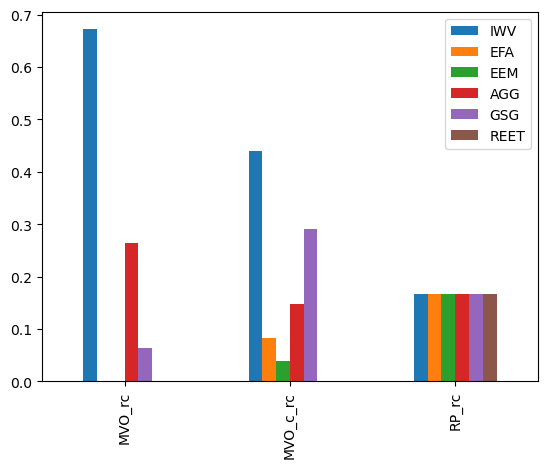

In [13]:
df_rc_proportion.plot(kind='bar')

<Axes: >

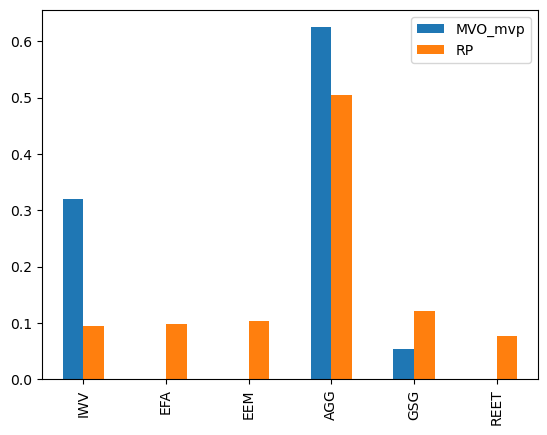

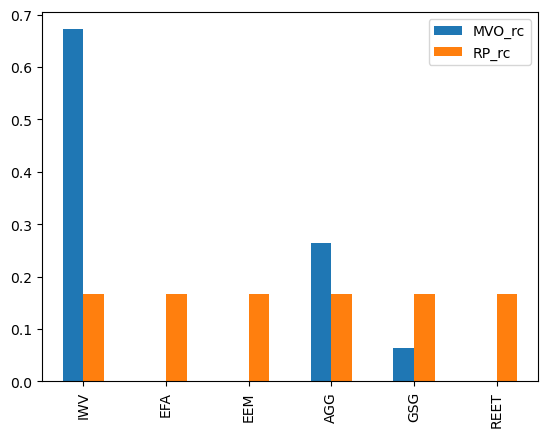

In [19]:
df_pfo.drop('MVO_mvp_c').T.plot(kind='bar')
df_rc_proportion.drop('MVO_c_rc').T.plot(kind='bar')